<a href="https://colab.research.google.com/github/Ayanp345/DeepSphere-spherical-CNN/blob/main/Spherical_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!git clone https://github.com/jonas-koehler/s2cnn.git

%cd s2cnn

!pip install -e .

Cloning into 's2cnn'...
remote: Enumerating objects: 851, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 851 (delta 90), reused 72 (delta 71), pack-reused 732 (from 1)
Receiving objects: 100% (851/851), 954.60 KiB | 34.09 MiB/s, done.
Resolving deltas: 100% (454/454), done.
/content/s2cnn
Obtaining file:///content/s2cnn
  Preparing metadata (setup.py) ... done
  Running setup.py develop for s2cnn


In [2]:
!pip install torch torchvision numpy matplotlib seaborn scikit-learn
!pip install s2cnn

In [3]:
import torch
print("Torch version:", torch.__version__)
print("GPU available:", torch.cuda.is_available())

Torch version: 2.9.0+cu126
GPU available: True


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
!pip install e3nn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.4/450.4 kB 31.7 MB/s eta 0:00:00


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
from torch.utils.data import DataLoader, random_split

# Transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Full training set (50,000)
full_trainset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

# Test set (10,000)
testset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

# Split: 45k train / 5k validation
train_size = int(0.9 * len(full_trainset))
val_size = len(full_trainset) - train_size

trainset, valset = random_split(
    full_trainset, [train_size, val_size]
)

# DataLoaders
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
valloader = DataLoader(valset, batch_size=32, shuffle=False)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

print("Train size:", len(trainset))
print("Validation size:", len(valset))
print("Test size:", len(testset))


100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


Train size: 45000
Validation size: 5000
Test size: 10000


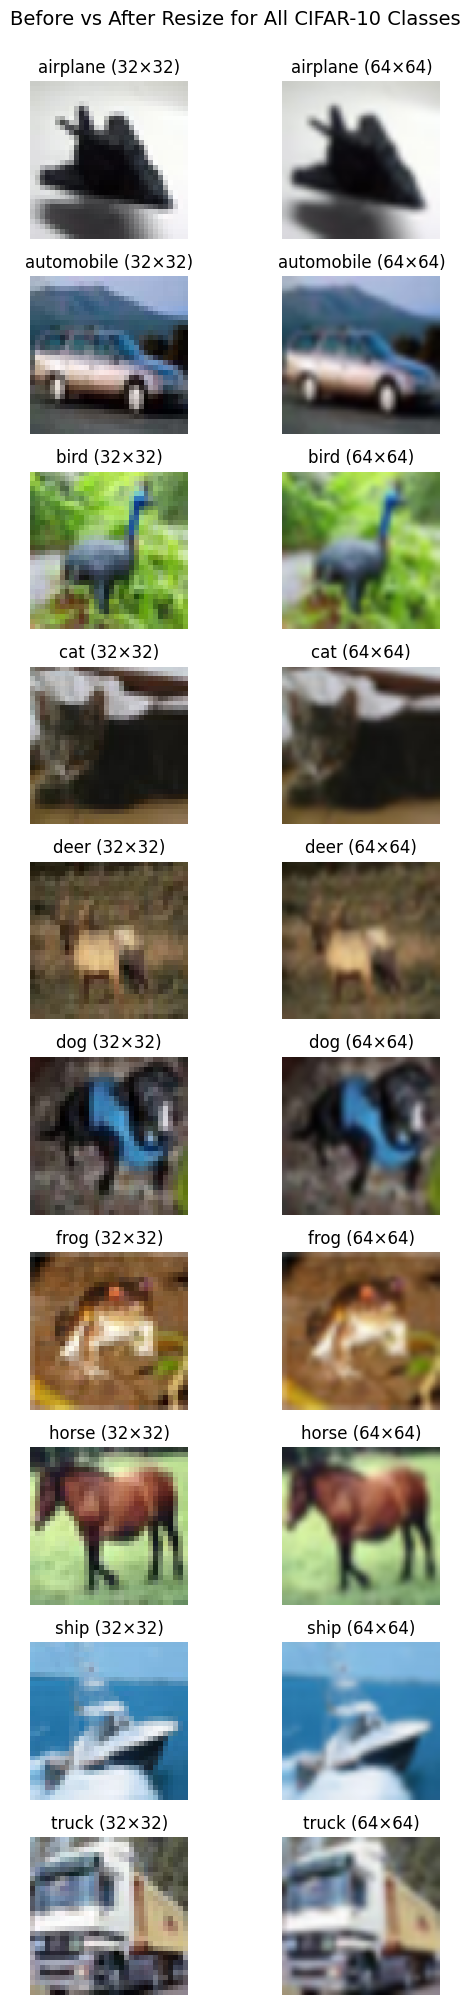

In [8]:
# CIFAR-10 class names
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Original dataset (32×32)
original_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

# Resized dataset (64×64)
resized_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor()
    ])
)

# Find one image index per class
class_indices = {}
for idx, (_, label) in enumerate(original_dataset):
    if label not in class_indices:
        class_indices[label] = idx
    if len(class_indices) == 10:
        break

# Plot: 10 rows × 2 columns
plt.figure(figsize=(6, 20))

row = 1
for label in range(10):
    idx = class_indices[label]

    orig_img, _ = original_dataset[idx]
    resized_img, _ = resized_dataset[idx]

    orig_img = orig_img.permute(1, 2, 0)
    resized_img = resized_img.permute(1, 2, 0)

    # Original
    plt.subplot(10, 2, row)
    plt.imshow(orig_img)
    plt.title(f"{class_names[label]} (32×32)")
    plt.axis("off")

    # Resized
    plt.subplot(10, 2, row + 1)
    plt.imshow(resized_img)
    plt.title(f"{class_names[label]} (64×64)")
    plt.axis("off")

    row += 2

plt.suptitle("Before vs After Resize for All CIFAR-10 Classes", fontsize=14, y=1)
plt.tight_layout()
plt.show()


In [9]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)   # EARLY
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # DEEP

        self.pool = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # 64 → 32
        x = self.pool(F.relu(self.conv2(x)))   # 32 → 16
        x = self.pool(F.relu(self.conv3(x)))   # 16 → 8

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [10]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 5

In [11]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    return 100 * correct / total


for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    val_acc = evaluate(model, valloader)
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss:.4f} | Val Acc: {val_acc:.2f}%")


Epoch 1/5 | Loss: 2014.4566 | Val Acc: 58.72%
Epoch 2/5 | Loss: 1412.4985 | Val Acc: 65.26%
Epoch 3/5 | Loss: 1135.3471 | Val Acc: 70.20%
Epoch 4/5 | Loss: 934.5397 | Val Acc: 71.38%
Epoch 5/5 | Loss: 749.9513 | Val Acc: 72.14%


In [12]:
test_acc = evaluate(model, testloader)
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 71.75%


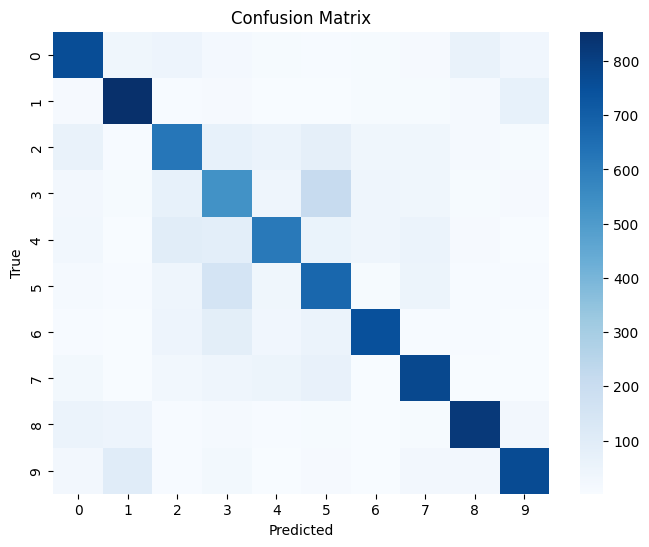

In [13]:
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [14]:
params = sum(p.numel() for p in model.parameters())
print("Total Parameters:", params)

Total Parameters: 2193226


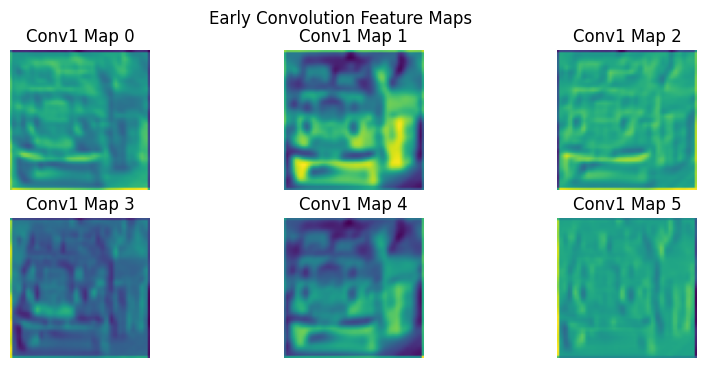

In [15]:
images, _ = next(iter(trainloader))
image = images[0].unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    early_features = model.conv1(image)

early_features = early_features.cpu()

plt.figure(figsize=(10,4))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(early_features[0, i], cmap="viridis")
    plt.title(f"Conv1 Map {i}")
    plt.axis("off")

plt.suptitle("Early Convolution Feature Maps")
plt.show()

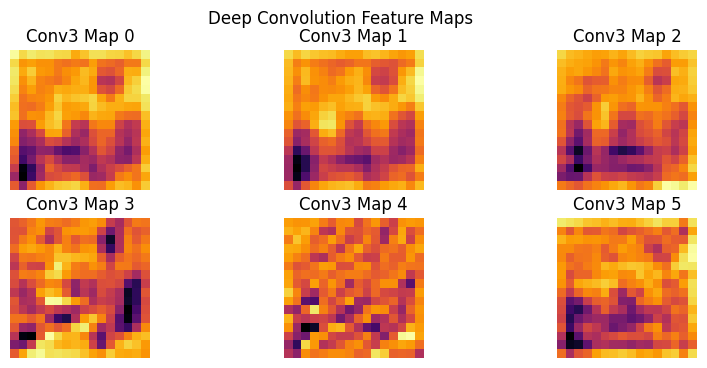

In [16]:
with torch.no_grad():
    x = F.relu(model.conv1(image))
    x = model.pool(x)

    x = F.relu(model.conv2(x))
    x = model.pool(x)

    deep_features = model.conv3(x)

deep_features = deep_features.cpu()

plt.figure(figsize=(10,4))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(deep_features[0, i], cmap="inferno")
    plt.title(f"Conv3 Map {i}")
    plt.axis("off")

plt.suptitle("Deep Convolution Feature Maps")
plt.show()

In [17]:
classes = ['airplane','automobile','bird','cat','deer',
           'dog','frog','horse','ship','truck']


In [18]:
model.eval()

# class_id : (max_value, image, feature_map)
max_activations = {i: (-1, None, None) for i in range(10)}

with torch.no_grad():
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)

        # EARLY convolution activations
        feature_maps = model.conv1(images)  # shape: [B, C, H, W]

        for i in range(images.size(0)):
            cls = labels[i].item()
            activation_value = feature_maps[i].max().item()

            if activation_value > max_activations[cls][0]:
                max_activations[cls] = (
                    activation_value,
                    images[i].cpu(),
                    feature_maps[i, 0].cpu()  # first channel
                )

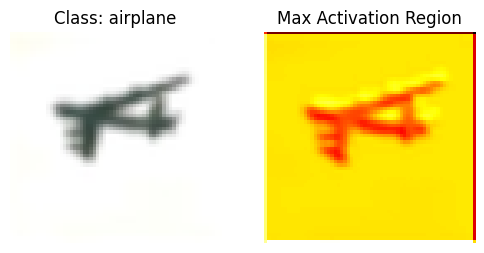

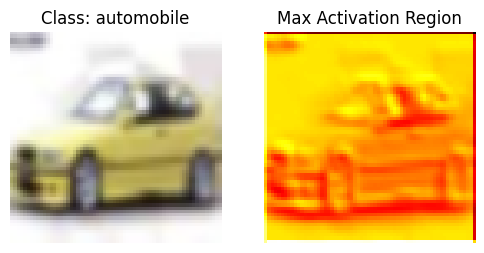

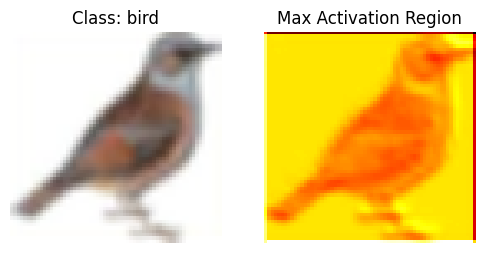

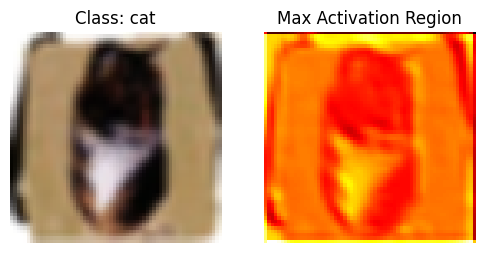

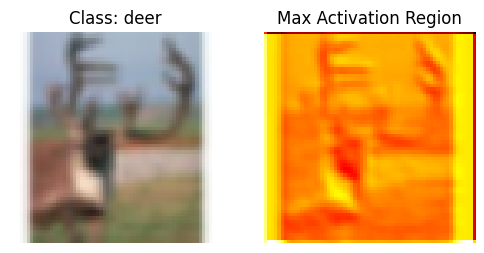

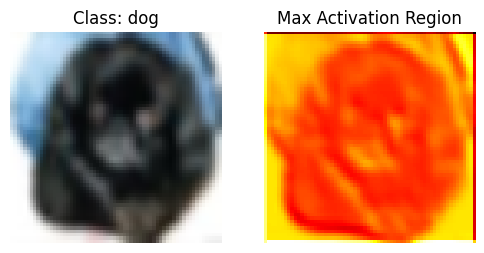

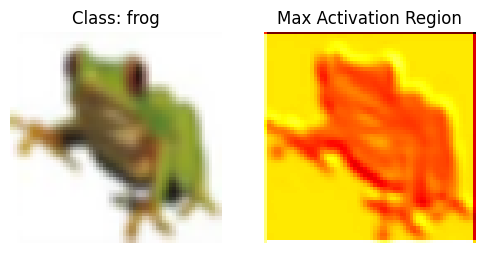

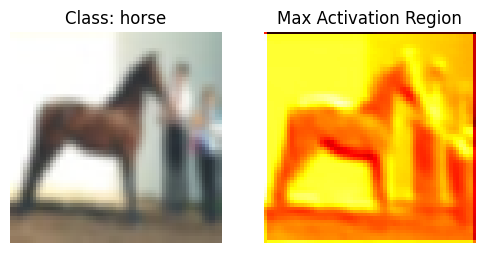

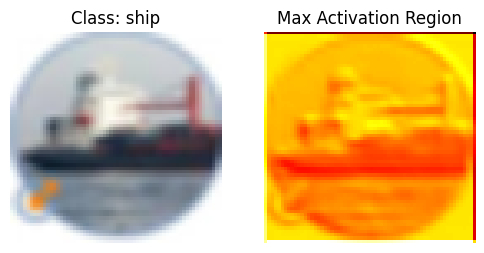

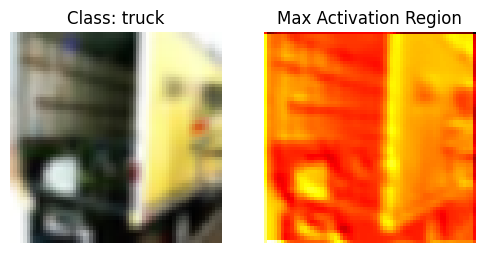

In [19]:
for cls in range(10):
    _, img, fmap = max_activations[cls]

    if img is None:
        continue

    plt.figure(figsize=(6,3))

    # Original Image
    plt.subplot(1,2,1)
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.title(f"Class: {classes[cls]}")
    plt.axis("off")

    # Activation Map
    plt.subplot(1,2,2)
    plt.imshow(fmap, cmap="hot")
    plt.title("Max Activation Region")
    plt.axis("off")

    plt.show()

In [24]:
class G1_SphericalInspired(nn.Module):
    """
    G1: Spherical CNN on S^2 (Approximated)
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        # Local feature extraction (spherical signal approx)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        # 🔑 Spherical integration over S^2
        x = x.mean(dim=[2, 3])  # global pooling

        return self.fc(x)

In [25]:
class G2_SO3Inspired(nn.Module):
    """
    G2: Spherical CNN on SO(3) (Approximated)
    """
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # Convert image to rotation-invariant descriptor
        x = x.mean(dim=[2, 3])  # invariant to rotation
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [22]:
g1_model = G1_SphericalInspired().to(device)
g2_model = G2_SO3Inspired().to(device)

print("G1 Model (S^2 – Spherical CNN Inspired):")
print(g1_model)

print("\nG2 Model (SO(3) – Rotation CNN Inspired):")
print(g2_model)

G1 Model (S^2 – Spherical CNN Inspired):
G1_SphericalInspired(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=64, out_features=10, bias=True)
)

G2 Model (SO(3) – Rotation CNN Inspired):
G2_SO3Inspired(
  (fc1): Linear(in_features=3, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [23]:
def count_params(model):
    return sum(p.numel() for p in model.parameters())

print("G1 Parameters:", count_params(g1_model))
print("G2 Parameters:", count_params(g2_model))

G1 Parameters: 20042
G2 Parameters: 906
